In [ ]:
#  https://github.com/zhangsz1998/CS294-158-Assignments/blob/master/hw1/Two-dimensional%20data%20-%20MADE.ipynb



In [75]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.init as init
from torch.optim import Adam, SGD
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

eps = np.finfo(float).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
sns.set()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### HW 1 1

Generate samples $x \in \{1, \ldots, 100 \} $

In [43]:
def sample_data(n_sample=10000):
    rand_state = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand_state.randn(n_sample)
    b = 0.8 + 0.05 * rand_state.randn(n_sample)
    mask = rand_state.rand(n_sample) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [3]:
samples = sample_data()
x_train = samples[:8000]
x_val = samples[8000:]

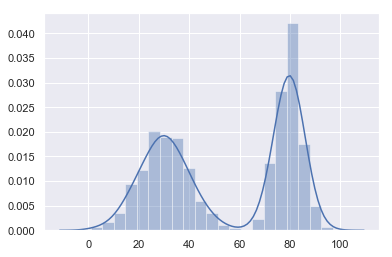

In [4]:
sns.distplot(samples)

Let $\theta = (\theta_1, \ldots, \theta_{100}) \in \mathbb{R}^{100}$. Then:
$$p_{\theta}(x) = \frac{e^{\theta_x}}{\sum_{x'} e^{\theta_{x'}}}$$

In [217]:
class h1model(nn.Module):
    def __init__(self, input_shape):
        super(h1model, self).__init__()
        self.input_shape = np.prod(input_shape)
        self.theta = nn.Parameter(torch.randn(self.input_shape, 1, requires_grad=True))
        
    def forward(self, x):
        nom = torch.exp(self.theta)
        denom = torch.sum(nom)
        res = nom / denom
        res = torch.gather(res, 0, x)
        return res

def train_validate(model, data, optim, loss_fn, train):
    batch_size = 1024
    model.train() if train else model.eval()
    
    if train:
        perm = torch.randperm(data.size(0))
        idx = perm[:batch_size]
        batch = data[idx]
    else:
        batch = data
        batch_size = data.size(0)
    
    # forward
    theta_hat = model(batch)
    loss = loss_fn(theta_hat)

    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()

    return loss.item()


def nn_loss(x):
    return torch.mean(-torch.log(x)) * torch.log2(torch.exp(torch.tensor(1.0)))

In [218]:
input_shape = (100, )
model = h1model(input_shape)
optim = Adam(model.parameters(), lr=0.001)
loss_fn = nn_loss
n_epochs = 5000

data = sample_data(n_sample=10000)
train, valid = train_test_split(data, test_size=0.2)
train = torch.from_numpy(train).unsqueeze(1).type(torch.LongTensor)
valid = torch.from_numpy(valid).unsqueeze(1).type(torch.LongTensor)

train_loss = []
val_loss = []
for epoch in range(0, n_epochs):    
    t_loss = train_validate(model, train, optim, loss_fn, train=True)
    train_loss.append(t_loss)
    
    if epoch % 100 == 0:
        v_loss = train_validate(model, valid, optim, loss_fn, train=False)
        val_loss.append(v_loss)

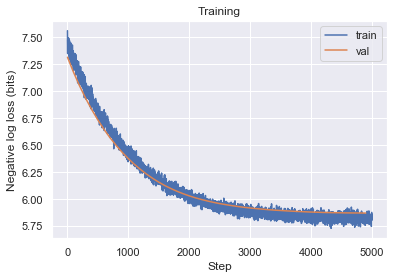

In [219]:
sns.set()
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 100, 100), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('Negative log loss (bits)')
plt.legend()
plt.grid(True)

In [241]:
theta_final = np.exp(model.theta.detach().squeeze(1).numpy())
theta_final /= sum(theta_final)

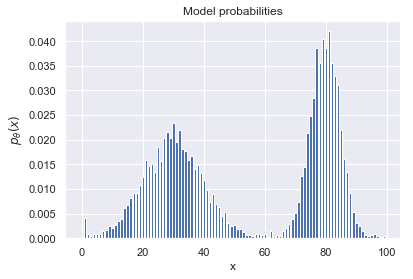

In [242]:
sns.set()
plt.bar(np.arange(len(theta_final)), theta_final)
plt.title('Model probabilities')
plt.xlabel('x')
plt.ylabel('$p_{\\theta}(x)$')
plt.grid(True)

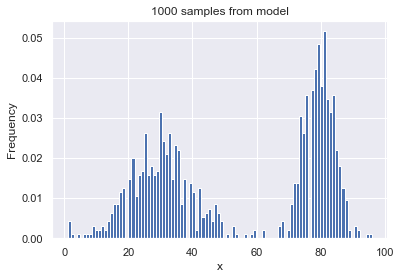

In [243]:
samples = np.random.choice(np.arange(100), p=theta_final, size=1000)
plt.hist(samples, bins=100, density=True)
plt.title('1000 samples from model')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)

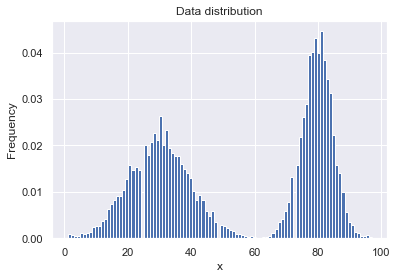

In [244]:
plt.hist(sample_data(), bins=100, density=True)
plt.title('Data distribution')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.grid(True)

## H 1 2
* Two dimensional data

In [7]:
p_x = np.load('distribution.npy')

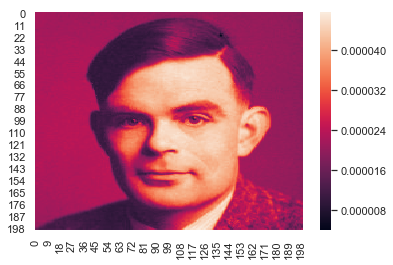

In [8]:
sns.heatmap(p_x)

#### Models
* $p_\theta(\mathbf{x}) = p_\theta(x_1)p_\theta(x_2 \vert x_1)$ where:
    $$p_{\theta}(x_1) = \frac{e^{\theta_{x_1}}}{\sum_{x_{1}'} e^{\theta_{x'_{1}}}}$$
and $p_\theta(x_2 \vert x_1)$ is some MLP


* $p_\theta(\mathbf{x})$ is represented as a Masked Autoencoder for Distribution Estimation (MADE)

In [38]:
def nn_loss(p_x1, p_x2x1):
    loss = torch.mean(-torch.log(p_x1) - torch.log(p_x2x1))
    loss *= torch.log2(torch.exp(torch.tensor(1.0)))
    return loss


def nn_loss2(p_x):
    loss = torch.mean(-torch.log(p_x))
    loss *= torch.log2(torch.exp(torch.tensor(1.0)))
    return loss


def train_validate(model, data, optim, loss_fn, train):
    batch_size = 5 * 1024
    model.train() if train else model.eval()
    
    if train:
        perm = torch.randperm(data.size(0))
        idx = perm[:batch_size]
        batch = data[idx]
    else:
        batch = data
        batch_size = data.size(0)
    
    # forward
    p_x, p_x1, p_x2x1 = model(batch)
#     loss = loss_fn(p_x1, p_x2x1)
    loss = loss_fn(p_x)

    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()

    return loss.item() / 2.0

def init_weights(module):
    for m in module.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            init.xavier_normal_(m.weight.data)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.Sequential):
            for sub_mod in m:
                init_weights(sub_mod)

                
def one_hot(labels, n_class):
    # Ensure labels are [N x 1]
    if len(list(labels.size())) == 1:
        labels = labels.unsqueeze(1)
    mask = torch.FloatTensor(labels.size(0), n_class).fill_(0)
    # scatter dimension, position indices, fill_value
    return mask.scatter_(1, labels, 1)


class model_px1(nn.Module):
    def __init__(self, input_shape):
        super(model_px1, self).__init__()
        self.input_shape = np.prod(input_shape)
        self.theta = nn.Parameter(torch.randn(self.input_shape, 1, requires_grad=True))
        
    def forward(self, x):
        nom = torch.exp(self.theta)
        denom = torch.sum(nom)
        res = nom / denom
        res = torch.gather(res, 0, x)
        return res
    

class model_px2x1(nn.Module):
    def __init__(self, input_shape):
        super(model_px2x1, self).__init__()
        self.input_shape = np.prod(input_shape)
        self.fc1 = nn.Linear(self.input_shape, self.input_shape * 2)
        self.drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(self.input_shape * 2, self.input_shape)
        self.sm = nn.Softmax(dim=0)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = self.fc1(x)
        h = self.drop(h)
        h = self.sm(self.fc2(h))
        return h


class model_theta(nn.Module):
    def __init__(self, input_shape):
        super(model_theta, self).__init__()
        self.input_shape = np.prod(input_shape)
        self.f_x1 = model_px1(self.input_shape)
        self.f_x2x1 = model_px2x1(self.input_shape)
        
    def forward(self, x):
        x1 = x[:, 0].unsqueeze(1)
        x2 = x[:, 1].unsqueeze(1)

        p_x1 = self.f_x1(x1)
        
        h_x2x1 = self.f_x2x1(one_hot(x1, self.input_shape))
        
        p_x2x1 = torch.gather(h_x2x1, 1, x2)
#         print(p_x2x1.size())
        return p_x1*p_x2x1, p_x1, p_x2x1

### Data

In [40]:
# Sample 100.000 points from this distribution, split 80/20 test train
p_x_true = np.load('distribution.npy')
samples = np.random.choice(np.prod(p_x_true.shape), p=p_x_true.ravel(), size=200000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_x, samples_y], axis=1)
train, valid = train_test_split(samples, test_size=0.4)

#### Visualize sampled distributions

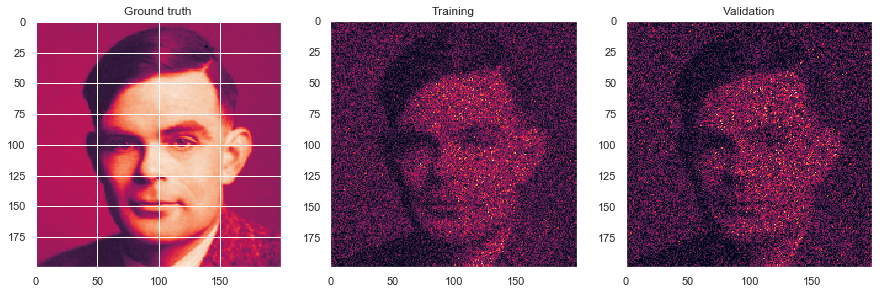

In [42]:
plt.rcParams['figure.figsize'] = 15, 5
fig, axis = plt.subplots(nrows=1, ncols=3)

axis[0].imshow(p_x_true)
axis[0].set_title('Ground truth')

axis[1].hist2d(train[:, 0], train[:, 1], bins=[200, 200])
axis[1].set_title('Training')
axis[1].set_aspect('equal', 'box')
axis[1].invert_yaxis()

axis[2].hist2d(valid[:, 0], valid[:, 1], bins=[200, 200])
axis[2].set_title('Validation')
axis[2].set_aspect('equal', 'box')
axis[2].invert_yaxis()

In [43]:
# Data
train = torch.from_numpy(train).type(torch.LongTensor)
valid = torch.from_numpy(valid).type(torch.LongTensor)

In [44]:
# Parameters
input_shape = (200, )
model = model_theta(input_shape)
optim = Adam(model.parameters(), lr=1e-3)
loss_fn = nn_loss2
n_epochs = 5000

train_loss = []
val_loss = []
for epoch in range(0, n_epochs):    
    t_loss = train_validate(model, train, optim, loss_fn, train=True)
    train_loss.append(t_loss)
    
    if epoch % 100 == 0:
        v_loss = train_validate(model, valid, optim, loss_fn, train=False)
        val_loss.append(v_loss)

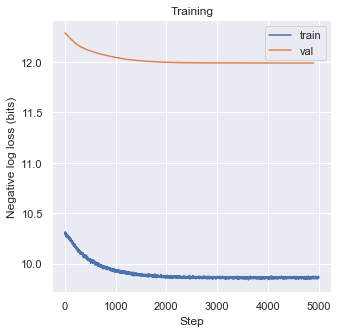

In [45]:
sns.set()
plt.rcParams['figure.figsize'] = 5, 5
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(0, len(val_loss) * 100, 100), val_loss, label='val')
plt.title('Training')
plt.xlabel('Step')
plt.ylabel('Negative log loss (bits)')
plt.legend()
plt.grid(True)

#### Get distribution

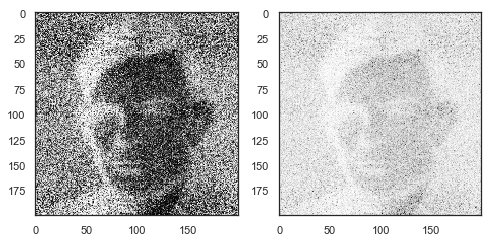

In [57]:
import cv2

grid = np.asarray([(x, y) for x in range(200) for y in range(200)])
grid = torch.from_numpy(grid).type(torch.LongTensor)
p_x, p_x1, p_x2x1 = model(grid)

draw = p_x.detach().numpy()

draw = draw.reshape((200, 200)).T
draw *= -1
im = 255*(draw - np.min(draw)) / (np.max(draw) - np.min(draw))

plt.rcParams['figure.figsize'] = 8, 8
with sns.axes_style('white'):
    fig, axis = plt.subplots(nrows=1, ncols=2)
    
    axis[0].imshow(cv2.equalizeHist(im.astype(np.uint8)), cmap='gray')
    axis[0].set_title('')
    
    axis[1].imshow(im, cmap='gray')
    axis[1].set_title('')

plt.grid(False)

#### Sample from distribution

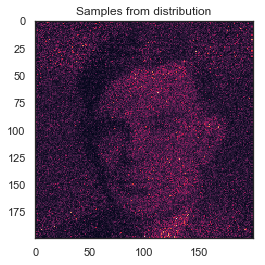

In [84]:
p_x_last = p_x.detach().numpy()
p_x_last /= np.sum(p_x_last)
samples = np.random.choice(np.prod(p_x_last.shape), p=p_x_last.ravel(), size=1000000)
samples_x = samples % 200
samples_y = samples // 200
samples = np.stack([samples_y, samples_x], axis=1)

plt.rcParams['figure.figsize'] = 4, 4
with sns.axes_style('white'):
    fig, axis = plt.subplots()
    axis.hist2d(samples[:, 0], samples[:, 1], bins=[200, 200])
    axis.set_title('Samples from distribution')
    axis.invert_yaxis()
    axis.set_aspect('equal', 'box')
    plt.grid(False)